# STEP 01. Load Libraries

In [1]:
import torch
import torch.nn as nn
import torch.utils.checkpoint as checkpoint
from timm.models.layers import DropPath, to_2tuple, trunc_normal_

# STEP 02. MODELING

## 1)Embeddings

In [ ]:
class embeddings(nn.Module):
    def __init__(self, 
                 img_size: int | tuple = 224, 
                 patch_size: int = 4, 
                 in_chans: int = 3, 
                 embed_dim: int = 96, 
                 norm_layer=None, 
                 drop: float = 0.0):
        super().__init__()
        # 이미지 크기 설정. 튜플이 아닐 경우 to_2tuple 함수를 통해 튜플로 변환
        self.img_size = img_size if isinstance(img_size, tuple) else to_2tuple(img_size)
        # 패치 크기 설정
        self.patch_size = patch_size
        # 이미지를 패치로 나눈 해상도 계산 (이미지 크기를 패치 크기로 나눔)
        self.patches_resolution = [self.img_size[0] // patch_size, self.img_size[1] // patch_size]
        # 전체 패치의 수 계산
        self.num_patches = self.patches_resolution[0] * self.patches_resolution[1]

        # 입력 채널 수와 임베딩 차원 설정
        self.in_chans = in_chans
        self.embed_dim = embed_dim

        # 2D 합성곱 레이어를 사용하여 패치 임베딩 수행
        self.patch_embeddings = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)        
        # 정규화 레이어 설정. 주어진 norm_layer가 없을 경우 Identity 레이어 사용
        self.norm = norm_layer(embed_dim) if norm_layer is not None else nn.Identity()            
        # 드롭아웃 레이어 설정
        self.dropout = nn.Dropout(drop)

    def forward(self, x):        
        x = self.patch_embeddings(x).flatten(2).transpose(1, 2)
        # 정규화 레이어 적용 (norm_layer가 Identity일 경우 아무 변화 없음)
        if self.norm is not None:
            x = self.norm(x)
        return x

In [ ]:
sample = torch.rand(2,3,224,224)
embedding = embeddings()
embedding(sample).shape

torch.Size([2, 3136, 96])

## 2)W-MHA & SW-MHA

### Component #1: Cyclic Shift

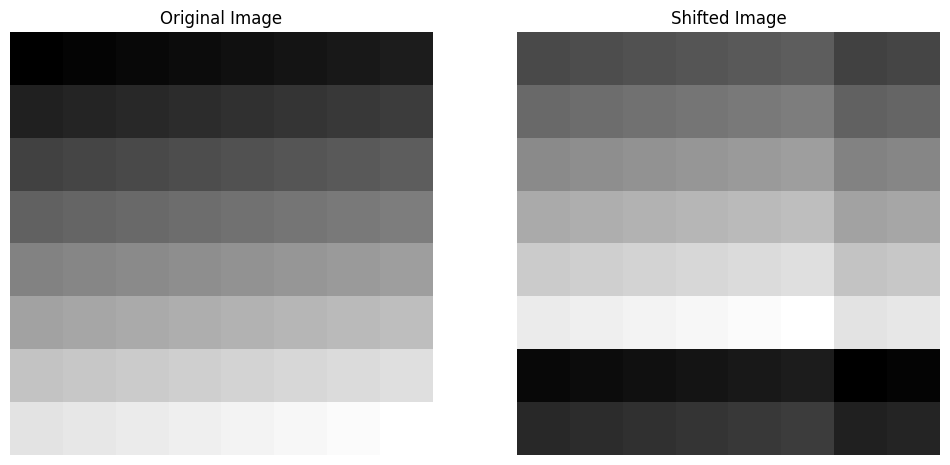

In [ ]:
import torch
import matplotlib.pyplot as plt

# 이미지 생성을 위한 임의의 데이터
B, H, W, C = 1, 8, 8, 1  # 배치 크기, 높이, 너비, 채널 수
img = torch.arange(B * H * W * C).view(B, H, W, C).float()

# Cyclic shift 함수 정의
def cyclic_shift(img, shift_size):
    """ 이미지에 대해 cyclic shift를 수행하는 함수 """
    shifted_img = torch.roll(img, shifts=(-shift_size, -shift_size), dims=(1, 2))
    return shifted_img

# Shift size 설정
shift_size = 2

# Cyclic shift 수행
shifted_img = cyclic_shift(img, shift_size)

# 결과 시각화
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(img.squeeze(), cmap='gray', interpolation='nearest')
ax[0].set_title('Original Image')
ax[0].axis('off')

ax[1].imshow(shifted_img.squeeze(), cmap='gray', interpolation='nearest')
ax[1].set_title('Shifted Image')
ax[1].axis('off')

plt.show()


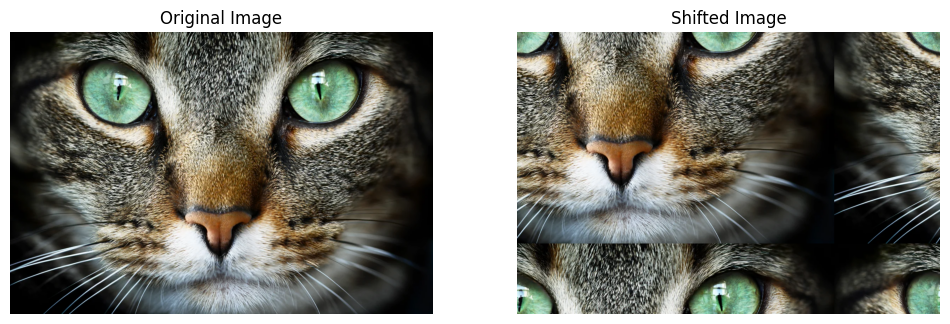

In [ ]:
from PIL import Image
import torchvision.transforms as T

# 이미지 파일을 읽어들이고, PIL Image 객체로 변환
image_path = 'cat.jpg'
image = Image.open(image_path)

# 이미지를 텐서로 변환
transform = T.ToTensor()
img_tensor = transform(image)

# Cyclic shift 함수 정의
def cyclic_shift(img_tensor, shift_h, shift_w):
    return torch.roll(img_tensor, shifts=(-shift_h, -shift_w), dims=(1, 2))

# Cyclic shift 수행 (여기서는 이미지의 1/4 크기만큼 시프트합니다)
shift_h, shift_w = img_tensor.shape[1] // 4, img_tensor.shape[2] // 4
shifted_img_tensor = cyclic_shift(img_tensor, shift_h, shift_w)

# 시프트된 이미지 텐서를 PIL 이미지로 변환
shifted_image = T.ToPILImage()(shifted_img_tensor)

# 원본 이미지와 시프트된 이미지를 시각화
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(image)
ax[0].set_title('Original Image')
ax[0].axis('off')

ax[1].imshow(shifted_image)
ax[1].set_title('Shifted Image')
ax[1].axis('off')

plt.show()


### Component #2: 상대적 위치편향(Relative Position Bias)

In [ ]:
# STEP 01 : X, Y축에 대한 위치 행렬 계산

import torch

window_size = 2
coords_h = coords_w= torch.arange(window_size)
coords = torch.stack(torch.meshgrid([coords_h, coords_w], indexing='ij'))
coords_flatten = torch.flatten(coords,1)
relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]

print("STEP 01: X,Y축에 대한 위치행렬 계산 결과")
print(relative_coords)

STEP 01: X,Y축에 대한 위치행렬 계산 결과
tensor([[[ 0,  0, -1, -1],
         [ 0,  0, -1, -1],
         [ 1,  1,  0,  0],
         [ 1,  1,  0,  0]],

        [[ 0, -1,  0, -1],
         [ 1,  0,  1,  0],
         [ 0, -1,  0, -1],
         [ 1,  0,  1,  0]]])


In [ ]:
# STEP 02 : Window 사이즈를 고려해 X, Y축에 대한 보정
x_coords = relative_coords[0, :, :]
y_coords = relative_coords[1, :, :]

x_coords += window_size - 1
y_coords += window_size - 1

x_coords *= 2* window_size - 1

print("STEP 02: Window Size를 고려한 보정된 위치행렬 계산 결과")
print(x_coords, y_coords, sep='\n')

# STEP 03 : X, Y축 위치행렬 정보를 종합
relative_position_index = x_coords + y_coords

print("\nSTEP 03: 종합적으로 고려된 위치행렬")
print(relative_position_index)

STEP 02: Window Size를 고려한 보정된 위치행렬 계산 결과
tensor([[3, 3, 0, 0],
        [3, 3, 0, 0],
        [6, 6, 3, 3],
        [6, 6, 3, 3]])
tensor([[1, 0, 1, 0],
        [2, 1, 2, 1],
        [1, 0, 1, 0],
        [2, 1, 2, 1]])

STEP 03: 종합적으로 고려된 위치행렬
tensor([[4, 3, 1, 0],
        [5, 4, 2, 1],
        [7, 6, 4, 3],
        [8, 7, 5, 4]])


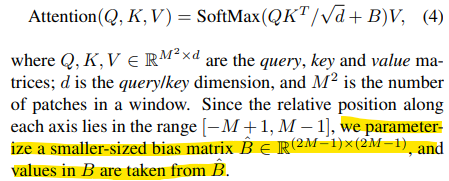

In [ ]:
def calculate_relative_position_index(window_size):
    coords_h = torch.arange(window_size[0])
    coords_w = torch.arange(window_size[1])
    coords = torch.stack(torch.meshgrid([coords_h, coords_w]))
    coords_flatten = torch.flatten(coords, 1)
    relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]
    relative_coords = relative_coords.permute(1, 2, 0).contiguous()
    relative_coords[:, :, 0] += window_size[0] - 1
    relative_coords[:, :, 1] += window_size[1] - 1
    relative_coords[:, :, 0] *= 2 * window_size[1] - 1
    return relative_coords.sum(-1)

In [ ]:
window_size = (2,2)
num_heads = 4

# 상대적 위치 바이어스 테이블 초기화
relative_position_bias_table = nn.Parameter(
    torch.zeros((2 * window_size[0] - 1) * (2 * window_size[1] - 1), num_heads))

# 상대적 위치 인덱스 계산
relative_position_index = calculate_relative_position_index(window_size)

print("\n[relative_position_index]\n", relative_position_index)
trunc_normal_(relative_position_bias_table, std=.02)
print("\n[relative_position_bias_table]\n", relative_position_bias_table)


[relative_position_index]
 tensor([[4, 3, 1, 0],
        [5, 4, 2, 1],
        [7, 6, 4, 3],
        [8, 7, 5, 4]])

[relative_position_bias_table]
 Parameter containing:
tensor([[ 0.0202, -0.0039,  0.0099,  0.0150],
        [-0.0451,  0.0044,  0.0204,  0.0328],
        [-0.0059, -0.0231, -0.0364,  0.0032],
        [ 0.0008,  0.0186,  0.0055, -0.0227],
        [-0.0149, -0.0027,  0.0188,  0.0136],
        [ 0.0227, -0.0246, -0.0160, -0.0373],
        [ 0.0073,  0.0195,  0.0348,  0.0092],
        [-0.0206, -0.0145,  0.0087,  0.0022],
        [-0.0080,  0.0189, -0.0134,  0.0026]], requires_grad=True)


/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [ ]:
relative_position_bias_table.shape

torch.Size([9, 4])

In [ ]:
relative_position_bias_table[relative_position_index.view(-1)].view(window_size[0] * window_size[1], window_size[0] * window_size[1], -1)

tensor([[[-0.0149, -0.0027,  0.0188,  0.0136],
         [ 0.0008,  0.0186,  0.0055, -0.0227],
         [-0.0451,  0.0044,  0.0204,  0.0328],
         [ 0.0202, -0.0039,  0.0099,  0.0150]],

        [[ 0.0227, -0.0246, -0.0160, -0.0373],
         [-0.0149, -0.0027,  0.0188,  0.0136],
         [-0.0059, -0.0231, -0.0364,  0.0032],
         [-0.0451,  0.0044,  0.0204,  0.0328]],

        [[-0.0206, -0.0145,  0.0087,  0.0022],
         [ 0.0073,  0.0195,  0.0348,  0.0092],
         [-0.0149, -0.0027,  0.0188,  0.0136],
         [ 0.0008,  0.0186,  0.0055, -0.0227]],

        [[-0.0080,  0.0189, -0.0134,  0.0026],
         [-0.0206, -0.0145,  0.0087,  0.0022],
         [ 0.0227, -0.0246, -0.0160, -0.0373],
         [-0.0149, -0.0027,  0.0188,  0.0136]]], grad_fn=<ViewBackward0>)

In [ ]:
relative_position_bias_table[relative_position_index.view(-1)].view(window_size[0] * window_size[1], window_size[0] * window_size[1], -1).shape

torch.Size([4, 4, 4])

### Component #3: Window Partition & Window Reverse

In [ ]:
def window_partition(x, window_size):
    """ 입력텐서(x)를 window_size 크기의 윈도우로 분할    
    
    """
    B, H, W, C = x.shape
    x = x.view(B, H // window_size, window_size, W // window_size, window_size, C)
    windows = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(-1, window_size, window_size, C)
    return windows # (num_windows, window_size, window_size, C)

def window_reverse(windows, window_size, H, W):
    """ window_partition을 통해 분할된 윈도우들을 원래 이미지로 복원
    
    """
    B = int(windows.shape[0] / (H * W / window_size / window_size))
    x = windows.view(B, H // window_size, W // window_size, window_size, window_size, -1)
    x = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(B, H, W, -1)
    return x # (B, H, W, C)


### Component #4: Windowed based MSA with Cyclic Shift, Relative Position Bias, Window Partition & Reverse

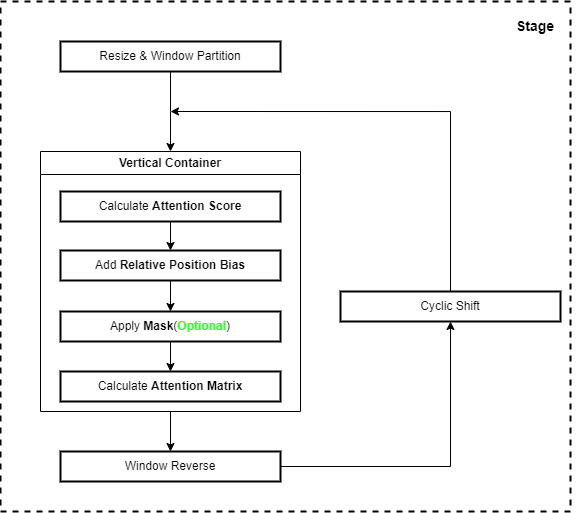

In [ ]:
class WindowAttention(nn.Module):
    """ 윈도우 기반 멀티헤드 셀프 어텐션 (W-MSA) 모듈. 시프트된 윈도우 지원.
    
    Args:
        dim (int): 입력 차원 수.
        window_size (tuple[int]): 윈도우의 높이와 너비.
        num_heads (int): 어텐션 헤드의 수.
        qkv_bias (bool, optional): QKV 선형 변환에 바이어스 추가 여부. 기본값: True.
        qk_scale (float | None, optional): Query-Key 스케일링 인자. 기본값: None(자동 계산).
        attn_drop (float, optional): 어텐션 가중치의 드롭아웃 비율. 기본값: 0.0.
        proj_drop (float, optional): 출력의 드롭아웃 비율. 기본값: 0.0.
    """
    def __init__(self, dim, window_size, num_heads, qkv_bias=True, qk_scale=None, attn_drop=0., proj_drop=0.):
        super().__init__()
        self.dim = dim  # 입력 차원
        self.window_size = window_size  # 윈도우 크기
        self.num_heads = num_heads  # 어텐션 헤드 수
        head_dim = dim // num_heads  # 각 헤드의 차원
        self.scale = qk_scale or head_dim ** -0.5  # 스케일링 인자

        # 상대적 위치 바이어스 테이블 초기화
        self.relative_position_bias_table = nn.Parameter(
            torch.zeros((2 * window_size[0] - 1) * (2 * window_size[1] - 1), num_heads))

        # 상대적 위치 인덱스 계산
        self.relative_position_index = self.calculate_relative_position_index(window_size)

        # QKV 선형 변환과 드롭아웃 레이어 초기화
        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)  # QKV 행렬 생성
        self.attn_drop = nn.Dropout(attn_drop)  # 어텐션 드롭아웃
        self.proj = nn.Linear(dim, dim)  # 최종 출력을 위한 선형 변환
        self.proj_drop = nn.Dropout(proj_drop)  # 출력 드롭아웃

        trunc_normal_(self.relative_position_bias_table, std=.02)  # 상대적 위치 바이어스 테이블 초기화
        self.softmax = nn.Softmax(dim=-1)  # 소프트맥스 함수

    def calculate_relative_position_index(self, window_size):
        # 상대적 위치 인덱스를 계산하는 내부 함수
        coords_h = torch.arange(window_size[0])
        coords_w = torch.arange(window_size[1])
        coords = torch.stack(torch.meshgrid([coords_h, coords_w]))  # 2차원 격자 생성
        coords_flatten = torch.flatten(coords, 1)  # 격자를 1차원으로 평탄화
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]  # 상대적 좌표 계산
        relative_coords = relative_coords.permute(1, 2, 0).contiguous()
        relative_coords[:, :, 0] += window_size[0] - 1
        relative_coords[:, :, 1] += window_size[1] - 1
        relative_coords[:, :, 0] *= 2 * window_size[1] - 1
        return relative_coords.sum(-1)  # 최종 상대적 위치 인덱스

    def forward(self, x, mask=None):
        # 순방향 전파 함수
        B_, N, C = x.shape  # 입력 텐서의 형태
        qkv = self.qkv(x).reshape(B_, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv.unbind(0)  # Q, K, V 분리

        q = q * self.scale  # 스케일링 적용
        attn = (q @ k.transpose(-2, -1))  # 어텐션 스코어 계산

        # 상대적 위치 편향 적용
        relative_position_bias = self.relative_position_bias_table[self.relative_position_index.view(-1)].view(
            self.window_size[0] * self.window_size[1], self.window_size[0] * self.window_size[1], -1)
        relative_position_bias = relative_position_bias.permute(2, 0, 1).contiguous()
        attn = attn + relative_position_bias.unsqueeze(0)

        # 마스크 적용 (필요한 경우)
        if mask is not None:
            nW = mask.shape[0]
            attn = attn.view(B_ // nW, nW, self.num_heads, N, N) + mask.unsqueeze(1).unsqueeze(0)
            attn = attn.view(-1, self.num_heads, N, N)
            attn = self.softmax(attn)
        else:
            attn = self.softmax(attn)

        attn = self.attn_drop(attn)  # 어텐션 드롭아웃 적용

        x = (attn @ v).transpose(1, 2).reshape(B_, N, C)  # 어텐션 적용 및 재구성
        x = self.proj(x)  # 최종 선형 변환
        x = self.proj_drop(x)  # 출력 드롭아웃 적용
        return x


## 3)MLP

In [ ]:
class Mlp(nn.Module):
    def __init__(self, 
                 in_features, 
                 hidden_features=None, 
                 out_features=None, 
                 act_layer=nn.GELU, 
                 drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

## 4)Swin Transformer Block

### LayerScale

In [ ]:
# transformer block에 작은 스케일 인자 곱하기
class LayerScale(nn.Module):
    def __init__(self, dim, init_values=1e-5):
        super().__init__()
        self.gamma = nn.Parameter(init_values * torch.ones((dim)))

    def forward(self, x):
        return self.gamma * x

### Calculate Attention Mask

In [ ]:
shift_size = 1
input_resolution = (4,4)
window_size = 2

def calculate_attn_mask():
    # 시프트된 윈도우 기반의 어텐션을 위한 마스크 계산
    if shift_size > 0:
        H, W = input_resolution
        img_mask = torch.zeros((1, H, W, 1))  # 이미지 마스크 초기화
        h_slices = [slice(0, -window_size),
                    slice(-window_size, -shift_size),
                    slice(-shift_size, None)]
        w_slices = [slice(0, -window_size),
                    slice(-window_size, -shift_size),
                    slice(-shift_size, None)]
        cnt = 0
        for h in h_slices:
            for w in w_slices:
                img_mask[:, h, w, :] = cnt
                cnt += 1
        mask_windows = window_partition(img_mask, window_size)
        mask_windows = mask_windows.view(-1, window_size * window_size)
        attn_mask = mask_windows.unsqueeze(1) - mask_windows.unsqueeze(2)
        attn_mask = attn_mask.masked_fill(attn_mask != 0, float(-100.0)).masked_fill(attn_mask == 0, float(0.0))
    else:
        attn_mask = None
        
    return attn_mask

attn_mask = calculate_attn_mask()
print(attn_mask.shape)
print(attn_mask)

torch.Size([4, 4, 4])
tensor([[[   0.,    0.,    0.,    0.],
         [   0.,    0.,    0.,    0.],
         [   0.,    0.,    0.,    0.],
         [   0.,    0.,    0.,    0.]],

        [[   0., -100.,    0., -100.],
         [-100.,    0., -100.,    0.],
         [   0., -100.,    0., -100.],
         [-100.,    0., -100.,    0.]],

        [[   0.,    0., -100., -100.],
         [   0.,    0., -100., -100.],
         [-100., -100.,    0.,    0.],
         [-100., -100.,    0.,    0.]],

        [[   0., -100., -100., -100.],
         [-100.,    0., -100., -100.],
         [-100., -100.,    0., -100.],
         [-100., -100., -100.,    0.]]])


In [ ]:
shift_size = 2
input_resolution = (6,6)
window_size = shift_size # 동일한 사이즈로 쉬프트하면 유출 없음 -> attn_mask 는 0행렬

def calculate_attn_mask():
    # 시프트된 윈도우 기반의 어텐션을 위한 마스크 계산
    if shift_size > 0:
        H, W = input_resolution
        img_mask = torch.zeros((1, H, W, 1))  # 이미지 마스크 초기화
        h_slices = [slice(0, -window_size),
                    slice(-window_size, -shift_size),
                    slice(-shift_size, None)]
        w_slices = [slice(0, -window_size),
                    slice(-window_size, -shift_size),
                    slice(-shift_size, None)]
        cnt = 0
        for h in h_slices:
            for w in w_slices:
                img_mask[:, h, w, :] = cnt
                cnt += 1
        mask_windows = window_partition(img_mask, window_size) # 이미지를 윈도우 사이즈로 분할
        mask_windows = mask_windows.view(-1, window_size * window_size)
        attn_mask = mask_windows.unsqueeze(1) - mask_windows.unsqueeze(2)
        attn_mask = attn_mask.masked_fill(attn_mask != 0, float(-100.0)).masked_fill(attn_mask == 0, float(0.0))
    else:
        attn_mask = None
        
    return attn_mask

attn_mask = calculate_attn_mask()
print(attn_mask.shape)
print(attn_mask)

torch.Size([9, 4, 4])
tensor([[[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]],

        [[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]],

        [[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]],

        [[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]],

        [[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]],

        [[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]],

        [[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]],

        [[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]],

        [[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0.,

In [ ]:
class SwinTransformerBlock(nn.Module):
    """Swin Transformer Block 클래스

    Args:
        dim (int): 입력 채널의 수.
        input_resolution (tuple[int]): 입력 해상도 (높이, 너비).
        num_heads (int): 어텐션 헤드의 수.
        window_size (int): 윈도우의 크기.
        shift_size (int): 윈도우 시프트 크기.
        mlp_ratio (float): MLP의 hidden dimension과 embedding dimension의 비율.
        qkv_bias (bool, optional): QKV에 바이어스 추가 여부.
        qk_scale (float | None, optional): QK 스케일링 인자 (기본값: head_dim ** -0.5).
        drop (float, optional): 드롭아웃 확률.
        attn_drop (float, optional): 어텐션 드롭아웃 확률.
        drop_path (float, optional): 드롭 패스 확률.
        act_layer (nn.Module, optional): 활성화 함수 레이어.
        norm_layer (nn.Module, optional): 정규화 레이어.
    """
    def __init__(self, dim, input_resolution, num_heads, window_size=7, shift_size=0,
                 mlp_ratio=4., qkv_bias=True, qk_scale=None, drop=0., attn_drop=0., drop_path=0.,
                 act_layer=nn.GELU, norm_layer=nn.LayerNorm):
        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.num_heads = num_heads
        self.window_size = window_size
        self.shift_size = shift_size
        self.mlp_ratio = mlp_ratio

        # 윈도우 크기가 입력 해상도보다 크거나 같으면 시프트 크기를 0으로 조정
        if min(self.input_resolution) <= self.window_size:
            self.shift_size = 0
            self.window_size = min(self.input_resolution)

        assert 0 <= self.shift_size < self.window_size, "shift_size는 0과 window_size 사이의 값이어야 함"

        # Layer 1: 정규화 레이어
        self.norm1 = norm_layer(dim)
        
        # Layer 2: 윈도우 기반 멀티헤드 셀프 어텐션 레이어
        self.attn = WindowAttention(
            dim, window_size=to_2tuple(self.window_size), num_heads=num_heads,
            qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop)

        # Layer 3: 드롭 패스 (스킵 커넥션의 드롭아웃)
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()

        # Layer 4: 두 번째 정규화 레이어
        self.norm2 = norm_layer(dim)

        # Layer 5: MLP 레이어
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

        # 어텐션 마스크 계산
        self._calculate_attn_mask()

    def _calculate_attn_mask(self):
        # 시프트된 윈도우 기반의 어텐션을 위한 마스크 계산
        if (self.shift_size > 0) or (self.shift_size != self.window_size):
            H, W = self.input_resolution
            img_mask = torch.zeros((1, H, W, 1))  # 이미지 마스크 초기화
            h_slices = [slice(0, -self.window_size),
                        slice(-self.window_size, -self.shift_size),
                        slice(-self.shift_size, None)]
            w_slices = [slice(0, -self.window_size),
                        slice(-self.window_size, -self.shift_size),
                        slice(-self.shift_size, None)]
            cnt = 0
            for h in h_slices:
                for w in w_slices:
                    img_mask[:, h, w, :] = cnt
                    cnt += 1
            mask_windows = window_partition(img_mask, self.window_size)
            mask_windows = mask_windows.view(-1, self.window_size * self.window_size)
            attn_mask = mask_windows.unsqueeze(1) - mask_windows.unsqueeze(2)
            attn_mask = attn_mask.masked_fill(attn_mask != 0, float(-100.0)).masked_fill(attn_mask == 0, float(0.0))
        else:
            attn_mask = None
        self.register_buffer("attn_mask", attn_mask)

    def forward(self, x):
        # 순방향 전파
        H, W = self.input_resolution
        B, L, C = x.shape
        assert L == H * W, "입력 특징의 크기가 올바르지 않음"

        shortcut = x
        x = self.norm1(x)
        x = x.view(B, H, W, C)

        # 순환 이동 및 윈도우 어텐션
        if self.shift_size > 0:
            shifted_x = torch.roll(x, shifts=(-self.shift_size, -self.shift_size), dims=(1, 2))
            x_windows = window_partition(shifted_x, self.window_size)
        else:
            x_windows = window_partition(x, self.window_size)
        x_windows = x_windows.view(-1, self.window_size * self.window_size, C)
        attn_windows = self.attn(x_windows, mask=self.attn_mask)

        # 윈도우 병합 및 순환 이동 복구
        attn_windows = attn_windows.view(-1, self.window_size, self.window_size, C)
        if self.shift_size > 0:
            shifted_x = window_reverse(attn_windows, self.window_size, H, W)
            x = torch.roll(shifted_x, shifts=(self.shift_size, self.shift_size), dims=(1, 2))
        else:
            x = window_reverse(attn_windows, self.window_size, H, W)
        x = x.view(B, H * W, C)

        # 잔차 연결 및 MLP
        x = shortcut + self.drop_path(x)
        x = x + self.drop_path(self.mlp(self.norm2(x)))

        return x


## 5)Patch Merging

In [ ]:
class PatchMerging(nn.Module):
    """ 패치 병합 레이어: 인접한 4개의 패치를 하나로 병합

    Args:
        input_resolution (tuple[int]): 입력 해상도 (높이, 너비)
        dim (int): 입력 채널 수
        norm_layer (nn.Module, optional): 정규화 레이어
    """
    def __init__(self, input_resolution, dim, norm_layer=nn.LayerNorm):
        super().__init__()
        self.input_resolution = input_resolution
        self.dim = dim
        self.reduction = nn.Linear(4 * dim, 2 * dim, bias=False)  # 차원 감소를 위한 선형 레이어
        self.norm = norm_layer(4 * dim)  # 정규화 레이어

    def forward(self, x):
        """
        x: (B, H*W, C) 형태의 텐서
        """
        H, W = self.input_resolution
        B, L, C = x.shape
        assert L == H * W, "입력 특징의 크기가 올바르지 않음"
        assert H % 2 == 0 and W % 2 == 0, "H와 W는 2의 배수여야 함"

        # 패치를 재배열하여 4개의 그룹으로 나눔
        x = x.view(B, H, W, C)
        x0 = x[:, 0::2, 0::2, :]  # 첫 번째 그룹
        x1 = x[:, 1::2, 0::2, :]  # 두 번째 그룹
        x2 = x[:, 0::2, 1::2, :]  # 세 번째 그룹
        x3 = x[:, 1::2, 1::2, :]  # 네 번째 그룹
        x = torch.cat([x0, x1, x2, x3], -1)  # 4개 그룹 연결
        x = x.view(B, -1, 4 * C)  # B, H/2*W/2, 4*C

        x = self.norm(x)  # 정규화
        x = self.reduction(x)  # 차원 감소

        return x


## 6)StageLayer

In [ ]:
class StageLayer(nn.Module):
    """ Swin Transformer의 기본 레이어: 여러 Swin Transformer 블록과 패치 병합 레이어 포함

    Args:
        dim (int): 입력 채널 수
        input_resolution (tuple[int]): 입력 해상도 (높이, 너비)
        depth (int): 블록의 수
        num_heads (int): 어텐션 헤드의 수
        window_size (int): 윈도우의 크기
        mlp_ratio (float): MLP의 hidden dimension과 embedding dimension의 비율
        qkv_bias (bool, optional): QKV에 바이어스 추가 여부
        qk_scale (float | None, optional): QK 스케일링 인자
        drop (float, optional): 드롭아웃 확률
        attn_drop (float, optional): 어텐션 드롭아웃 확률
        drop_path (float | tuple[float], optional): 드롭 패스 확률
        norm_layer (nn.Module, optional): 정규화 레이어
        downsample (nn.Module | None, optional): 다운샘플링 레이어
    """
    def __init__(self, dim, input_resolution, depth, num_heads, window_size,
                 mlp_ratio=4., qkv_bias=True, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., norm_layer=nn.LayerNorm, downsample=None):
        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.depth = depth

        # Swin Transformer 블록들을 순차적으로 구성
        self.blocks = nn.ModuleList([
            SwinTransformerBlock(dim=dim, input_resolution=input_resolution,
                                 num_heads=num_heads, 
                                 window_size=window_size,
                                 shift_size=0 if (i % 2 == 0) else window_size // 2,
                                 mlp_ratio=mlp_ratio,
                                 qkv_bias=qkv_bias, qk_scale=qk_scale,
                                 drop=drop, attn_drop=attn_drop,
                                 drop_path=drop_path[i] if isinstance(drop_path, list) else drop_path,
                                 norm_layer=norm_layer)
            for i in range(depth)])

        # 다운샘플링 레이어 (있을 경우)
        self.downsample = downsample(input_resolution, dim=dim, norm_layer=norm_layer) if downsample is not None else nn.Identity()

    def forward(self, x):
        for blk in self.blocks:
            x = blk(x)

        x = self.downsample(x)
        return x


## 7)Swin Transformer

In [ ]:
class SwinTransformer(nn.Module):
    """ Swin Transformer 전체 모델
    """
    def __init__(self, img_size=224, patch_size=4, in_chans=3, num_classes=1000,
                 embed_dim=96, depths=[2, 2, 6, 2], num_heads=[3, 6, 12, 24],
                 window_size=7, mlp_ratio=4., qkv_bias=True, qk_scale=None,
                 drop_rate=0., attn_drop_rate=0., drop_path_rate=0.1,
                 norm_layer=nn.LayerNorm, patch_norm=True,
                 **kwargs):
        super().__init__()

        self.num_classes = num_classes
        self.embed_dim = embed_dim
        self.patch_norm = patch_norm

        # 패치 임베딩 레이어
        self.embeddings = embeddings(
            img_size=img_size, patch_size=patch_size, in_chans=in_chans, embed_dim=embed_dim,
            norm_layer=norm_layer if patch_norm else None)

        # 스테이지별 레이어 생성
        self.stages = nn.ModuleList()
        for i_stage in range(len(depths)):
            layer = StageLayer(
                dim=int(embed_dim * 2 ** i_stage),
                input_resolution=(self.embeddings.patches_resolution[0] // (2 ** i_stage),
                                  self.embeddings.patches_resolution[1] // (2 ** i_stage)),
                depth=depths[i_stage],
                num_heads=num_heads[i_stage],
                window_size=window_size,
                mlp_ratio=mlp_ratio,
                qkv_bias=qkv_bias, qk_scale=qk_scale,
                drop=drop_rate, attn_drop=attn_drop_rate,
                drop_path=drop_path_rate,
                norm_layer=norm_layer,
                downsample=PatchMerging if i_stage < len(depths) - 1 else None,
                )
            self.stages.append(layer)
            
        final_dim = embed_dim * 2 ** (len(depths) - 1)  # 최종 차원 계산
        self.layernorm = norm_layer(final_dim)  # 최종 출력 정규화 레이어
        self.pooler = nn.AdaptiveAvgPool1d(1) # Global Average Pooling
        self.classifier = nn.Linear(final_dim, num_classes) if num_classes > 0 else nn.Identity()

    def forward(self, x):
        x = self.embeddings(x)        
        for stage in self.stages:
            x = stage(x)            
        x = self.layernorm(x)        
        x = self.pooler(x.transpose(1,2)).flatten(1)        
        x = self.classifier(x)
        return x

In [ ]:
model = SwinTransformer()
dummy_img = torch.randn(2, 3, 224, 224)
output = model(dummy_img)

print(output.shape)

torch.Size([2, 1000])


In [ ]:
for main_name, main_module in model.named_children():
    print("\n【", main_name, "】")
    for sub_name, sub_module in main_module.named_children():
        print(" ┠", sub_name)
        for ssub_name, ssub_module in sub_module.named_children():
            print(" ┃ └", ssub_name)


【 embeddings 】
 ┠ patch_embeddings
 ┠ norm
 ┠ dropout

【 stages 】
 ┠ 0
 ┃ └ blocks
 ┃ └ downsample
 ┠ 1
 ┃ └ blocks
 ┃ └ downsample
 ┠ 2
 ┃ └ blocks
 ┃ └ downsample
 ┠ 3
 ┃ └ blocks
 ┃ └ downsample

【 layernorm 】

【 pooler 】

【 classifier 】


In [ ]:
from torchsummary import summary

summary(model.cuda(), (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 56, 56]           4,704
         LayerNorm-2             [-1, 3136, 96]             192
        embeddings-3             [-1, 3136, 96]               0
         LayerNorm-4             [-1, 3136, 96]             192
            Linear-5              [-1, 49, 288]          27,936
           Softmax-6            [-1, 3, 49, 49]               0
           Dropout-7            [-1, 3, 49, 49]               0
            Linear-8               [-1, 49, 96]           9,312
           Dropout-9               [-1, 49, 96]               0
  WindowAttention-10               [-1, 49, 96]               0
         DropPath-11             [-1, 3136, 96]               0
        LayerNorm-12             [-1, 3136, 96]             192
           Linear-13            [-1, 3136, 384]          37,248
             GELU-14            [-1, 31

In [ ]:
model

SwinTransformer(
  (embeddings): embeddings(
    (patch_embeddings): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
    (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (stages): ModuleList(
    (0): StageLayer(
      (blocks): ModuleList(
        (0-1): 2 x SwinTransformerBlock(
          (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
          (attn): WindowAttention(
            (qkv): Linear(in_features=96, out_features=288, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=96, out_features=96, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
            (softmax): Softmax(dim=-1)
          )
          (drop_path): DropPath(drop_prob=0.100)
          (norm2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=96, out_features=384, bias=True)
            (act): GELU(approx

# STEP 03. DATA LOAD

In [ ]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as T

2023-12-22 18:10:56.641700: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-22 18:10:56.641762: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-22 18:10:56.642477: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-22 18:10:56.647789: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-22 18:10:57.451449: W tensorflow/compiler/tf2

In [ ]:
data_dir = '../data/sports/'
batch_size = 256

# T 정의하기
train_transform = T.Compose([
    T.RandomResizedCrop(224, scale=(0.8,1), interpolation=T.InterpolationMode.LANCZOS),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    T.RandomErasing(p=0.9, scale=(0.02, 0.33)),
])

test_transform = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


train_path = data_dir+'/train'
valid_path = data_dir+'/valid'
test_path = data_dir+'/test'

# dataset load
train_data = ImageFolder(train_path, transform=train_transform)
valid_data = ImageFolder(valid_path, transform=test_transform)
test_data = ImageFolder(test_path, transform=test_transform)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# STEP 04. TRAIN

In [ ]:
import torch.optim as optim
from torch.cuda.amp import autocast, GradScaler
import time
from tqdm import tqdm

In [ ]:
label_smoothing = 0.1
learning_rate = 1e-3
epochs = 10
device = 'cuda:2'

In [ ]:
model.to(device)

criterion = nn.CrossEntropyLoss(label_smoothing=label_smoothing)
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=len(train_loader)*5, gamma=0.8)

training_time = 0
losses = []
val_losses = []
lrs = []
best_loss = float('inf')

# GradScaler 초기화
scaler = GradScaler()

for epoch in range(epochs):
    model.train()
    start_time = time.time()
    running_loss = 0.0
    pbar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch + 1}")
    
    for i, data in pbar:
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()

        # AutoCast 적용
        with autocast():
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Scaled Backward & Optimizer Step
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()
            
            lr = optimizer.param_groups[0]["lr"]
            lrs.append(lr)
        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    losses.append(epoch_loss)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for data in valid_loader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
    val_loss /= len(valid_loader)
    val_losses.append(val_loss)
    
    # 모델 저장
    if val_loss < best_loss:
        best_loss = val_loss
        vit_save = True
        # torch.save(model.state_dict(), model_path)

    epoch_duration = time.time() - start_time
    training_time += epoch_duration
    
    text = f'\tLoss: {epoch_loss}, Val Loss: {val_loss}, LR: {lr}, Duration: {epoch_duration:.2f} sec'
    
    if vit_save:
        text += f' - model saved!'
        vit_save = False

    print(text)
        
text = f"Epoch 당 평균 소요시간 : {training_time / epochs:.2f}초"
  
print(text)
    


Epoch 1: 100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


	Loss: 6.828225612640381, Val Loss: 5.689422130584717, LR: 0.001, Duration: 3.28 sec - model saved!


Epoch 2: 100%|██████████| 2/2 [00:01<00:00,  1.15it/s]


	Loss: 5.429693937301636, Val Loss: 5.219280958175659, LR: 0.001, Duration: 2.71 sec - model saved!


Epoch 3: 100%|██████████| 2/2 [00:01<00:00,  1.17it/s]


	Loss: 5.136472702026367, Val Loss: 5.054531574249268, LR: 0.001, Duration: 2.64 sec - model saved!


Epoch 4: 100%|██████████| 2/2 [00:01<00:00,  1.17it/s]


	Loss: 5.05063796043396, Val Loss: 5.003724575042725, LR: 0.001, Duration: 2.63 sec - model saved!


Epoch 5: 100%|██████████| 2/2 [00:01<00:00,  1.14it/s]


	Loss: 4.971331357955933, Val Loss: 4.987758636474609, LR: 0.0008, Duration: 2.72 sec - model saved!


Epoch 6: 100%|██████████| 2/2 [00:01<00:00,  1.15it/s]


	Loss: 4.867830753326416, Val Loss: 4.941912651062012, LR: 0.0008, Duration: 2.67 sec - model saved!


Epoch 7: 100%|██████████| 2/2 [00:01<00:00,  1.17it/s]


	Loss: 4.774473667144775, Val Loss: 4.887077569961548, LR: 0.0008, Duration: 2.67 sec - model saved!


Epoch 8: 100%|██████████| 2/2 [00:01<00:00,  1.18it/s]


	Loss: 4.722314119338989, Val Loss: 4.876807928085327, LR: 0.0008, Duration: 2.63 sec - model saved!


Epoch 9: 100%|██████████| 2/2 [00:01<00:00,  1.18it/s]


	Loss: 4.67487359046936, Val Loss: 4.852883577346802, LR: 0.0008, Duration: 2.63 sec - model saved!


Epoch 10: 100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


	Loss: 4.605339050292969, Val Loss: 4.868885040283203, LR: 0.00064, Duration: 2.73 sec
Epoch 당 평균 소요시간 : 2.73초


In [ ]:
# 예측 수행 및 레이블 저장
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())